In [1]:
# Load packages
import pandas as pd
import numpy as np
import re
import math
from time import strptime  # format data columns
import random  # used in subsampling
import warnings
import seaborn as sns
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")  # ignore warnings throughout notebook
pd.set_option("display.max_columns", None)  # show all columns

In [2]:
# Load Data
file_path = "./data/accepted_subsampled_5percent.csv" #will be personalized
df = pd.read_csv(file_path, sep=",")

# Question Group: Warmup Questions
- The dataset contains $2.2M+$ of approved loans and $20M+$ rejected 
loan applications

### Question 1:

Among all the  151 columns of the loan data set, which information is known at the time of loan issuance?

In [2]:
# We should create two variables containing a list of all varaibles known
# and unknown at the time of the loan. Will need to separate for future
# analyses or ML

### Question 2:

Which columns are related to borrowers's credit history and demographic information?

### Question 3:

Which columns store loan-specific information?

### Question 4:

How does the issued loans vary year after year?

### Question 5:

What are the purposes of applying Lending Club loans?

### Question 6:

Do you observe different loan grade patterns for different loan purposes?

### Question 7:

Do you observe different loan grade patterns in different years?

### Question 8:

How about loan counts stratified into years and loan purposes/loan grades?

### Question 9:

How are the loan amounts/funded amounts distributed?

### Question 10:

Are there variations across different loan purposes, loan grades, etc?

### Question 11:

Are loans with higher funded amounts harder to be paid-in-full?

# Question Group: Interest Rates
- For borrowers, the most important factor is interest rate charged.

### Question 12:

Provide insights on the interest rates dependence on loan grade/subgrade and term (36 or 60 months).

### Question 13:

If the analysis is refined by separating loans with different start months (the year-month loan issuance date), report your finding.

### Question 14:

Any rational explanation on why the interest rate should be grade/sub-grade dependent?

### Question 15:

Any rational explanation on the time series variations of interest rates?

### Question 16:

Any rational explanation why the interest rate rise w.r.t. loan term?

# Question Group: Loan Status
 - For investors, it is crucial to know whether a loan is served to completion (loan_status 'Fully Paid').

### Question 17:

Please analyze the percentages of non-completed loans in each loan grade/subgrade (i.e. default, charged off) which go beyond delinquency.

### Question 18:

Provide justification the introduction of loan grade/subgrade.

### Question 19:

Provide justification on the rate hike on riskier loan grade/subgrade.

### Question 20:

What happens to percentage rates of loans involving settlement?

### Question 21:

Make sure that your analysis takes into account of loan-term.

# Question Group: Amortization Process
 - For investors, the amortization process returns the partial principal and monthly interest in a single montly installment payment.

### Question 22:

Because the borrower can pre-pay the principal at-will or go belly-up (delinquent or default) at any moment within the loan term, it may shorten the loan duration un-expectedly or cause losses to the investors.

### Question 23:

Thus it is vital for the investors to know the general pattern of loan-prepayment or delinquency (early stage leading to default or eventual charged off).

### Question 24:

Please compute the actual durations of loans (last_payment_date - issuance_date):
 - analyze the pattern debtors terminate the loans before loan maturity (either 'fully paid', or stop paying henceforth).
 - Please include 'term', 'loan-grade/sub-grade' in your analysis.

### Question 25:

Do you see major differences on the patterns with different loan-terms? What is the rational explanation for this difference?
 - Report the major characteristics of the patterns.

### Question 26:

Do '60 months' (5 years) loans often get terminated at the end of the 5 years loan term? Why not?

# Question Group: Profitability

- For investors, the profitability of the loans is of their central 
concern.

### Question 27:

For a given loan, the profit-and-loss (in percentages) can be computed as the (total_payment - principal)/principal.

In [36]:
# Clean up and add columns
df['term_year'] = np.where(df['term']==' 36 months', 3,5)
avg_term = sum(df['term_year']*df['funded_amnt'])/sum(df['funded_amnt'])
df['loan_status'] = df['loan_status'].str.replace('(', '').str.replace(')', '')

### Question 28:

For those loans which are eventually 'Fully Paid', what are the average returns (or the distributions of returns) of different loan grades/terms?

In [5]:
# Function to calculate annual return
def return_cal(df, total_payment="total_pymnt", funded_payment="funded_amnt", term_in_year="term_year"):
    if term_in_year == "avg_term":
        return 100*((df[total_payment]/df[funded_payment])**(1/df[term_in_year])-1)
    else:
        return 100*((df[total_payment]/df[funded_payment])**(1/avg_term)-1)

,grade,return_perc
0,A,2.155852
1,B,3.261751
2,C,4.246818
3,D,5.287047
4,E,6.357632
5,F,7.354346
6,G,7.119898


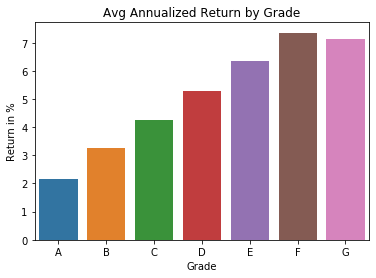

In [6]:
# This is a simple average of all loans not asset weighted. 
df_fully_paid = df[df['loan_status'].str.contains('Fully Paid')]
df_fully_paid['return_perc'] =  return_cal(df_fully_paid)
return_grade = df_fully_paid.groupby('grade')[['return_perc']].mean().reset_index()

grade_plot = sns.barplot(x="grade", y="return_perc", data=return_grade)
grade_plot.set(title = 'Avg Annualized Return by Grade', xlabel = 'Grade', ylabel = 'Return in %' )

return_grade

,grade,funded_amnt,total_pymnt,return_perc
0,A,156680975.0,1.701844e+08,2.203863
1,B,222818950.0,2.526315e+08,3.366617
2,C,208655800.0,2.459196e+08,4.428123
3,D,105216975.0,1.290040e+08,5.521501
4,E,49402350.0,6.327334e+07,6.742991
5,F,15345400.0,2.022847e+07,7.556967
6,G,4878975.0,6.387143e+06,7.360790


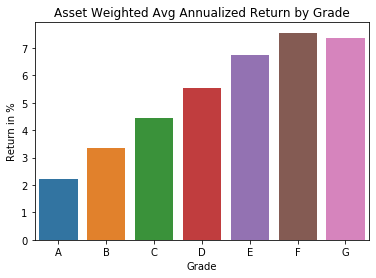

In [240]:
# This is asset weighted return
return_grade_wt = df_fully_paid.groupby('grade')[['funded_amnt','total_pymnt']].sum().reset_index()
return_grade_wt['return_perc'] =  return_cal(return_grade_wt,"total_pymnt",'funded_amnt', avg_term)

grade_wt_plot = sns.barplot(x="grade", y="return_perc", data=return_grade_wt)
grade_wt_plot.set(title = 'Asset Weighted Avg Annualized Return by Grade', xlabel = 'Grade', ylabel = 'Return in %' )

return_grade_wt

### Question 29:

For those loans wich are default or beyond, what are the average returns or return distributions?

[Text(0, 0.5, 'Return in %'),
 Text(0.5, 0, 'Grade'),
 Text(0.5, 1.0, 'Avg Annualized Return by Grade')]

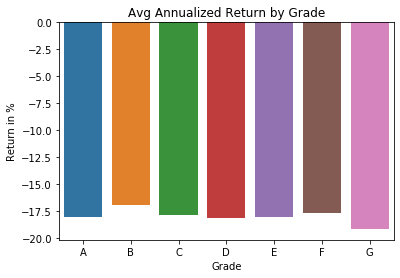

In [9]:
df_default = df[df['loan_status'].str.contains('Charged Off')]
df_default['return_perc'] =  return_cal(df_default)
return_grade_default = df_default.groupby('grade')[['return_perc']].mean().reset_index()
default_plot = sns.barplot(x="grade", y="return_perc", data=return_grade_default)
default_plot.set(title = 'Avg Annualized Return by Grade', xlabel = 'Grade', ylabel = 'Return in %' )

### Question 30:

What about all the loans which have been terminated ('fully paid', 'default', 'charged off')?

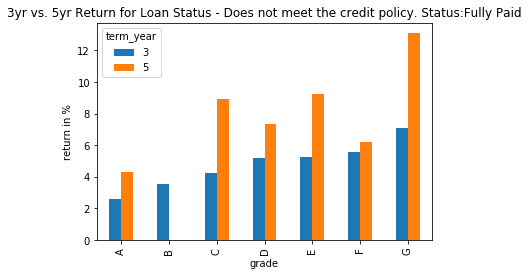

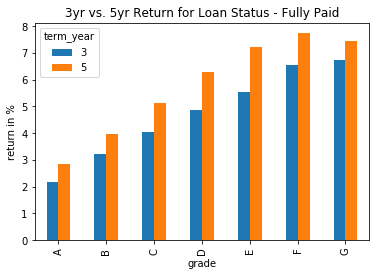

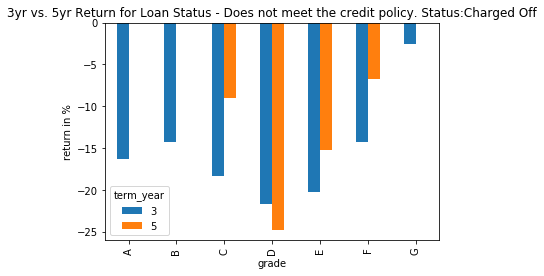

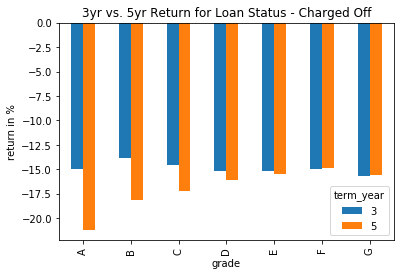

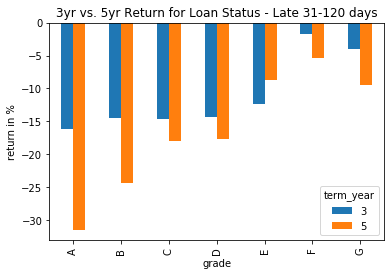

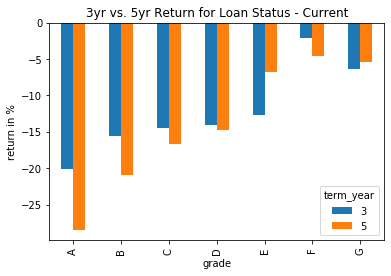

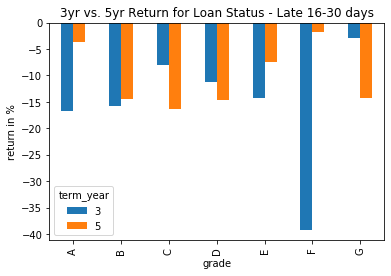

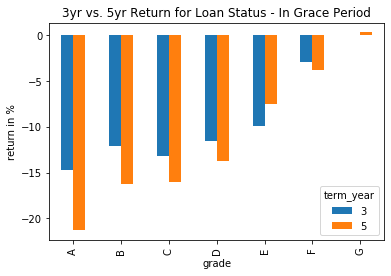

In [39]:
# 3 and 5 year return for each loan status
for status in df['loan_status'].unique():
    df_status = df[df['loan_status'].str.contains(status)]
    df_term_comp = df_status.groupby(['grade','term_year'])[['funded_amnt','total_pymnt']].sum().reset_index()
    df_term_comp['return_perc'] =  return_cal(df_term_comp)
    df_term_comp_graph = pd.pivot_table(df_term_comp, index = 'grade',values = 'return_perc', columns = 'term_year').fillna(0)
    df_term_comp_graph.plot(kind="bar")
    plt.title('3yr vs. 5yr Return for Loan Status - ' + status)
    plt.ylabel('return in %')

### Question 31:

What about the loans which end up in loan settlement negotiations?

### Question 32:

Any variation of patterns for different loan purposes?

In [327]:
purpose_comp['purpose'].unique()

array(['car', 'credit_card', 'debt_consolidation', 'educational',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation',
       'wedding'], dtype=object)

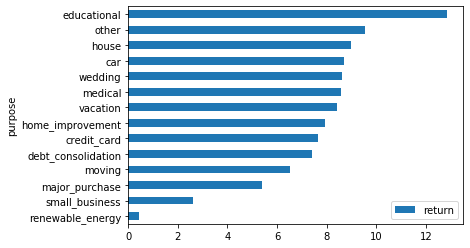

In [66]:
# Return by purpose (not annualized)
purpose_comp = df.loc[df.issue_year < 2016].groupby(['purpose'])[['funded_amnt','total_pymnt']].sum().reset_index()
purpose_comp['return']= 100*(purpose_comp['total_pymnt']/purpose_comp['funded_amnt']-1)
purpose_comp[['purpose','return']].sort_values('return').set_index('purpose').plot.barh()

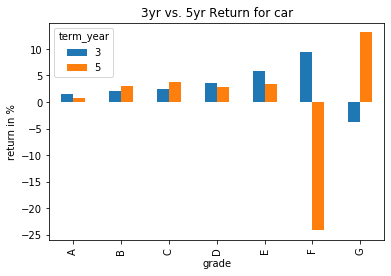

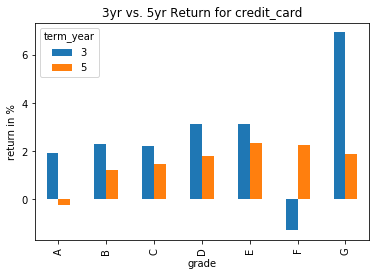

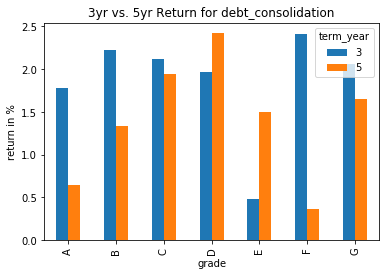

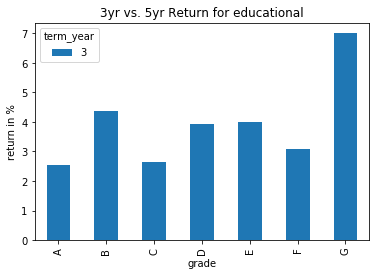

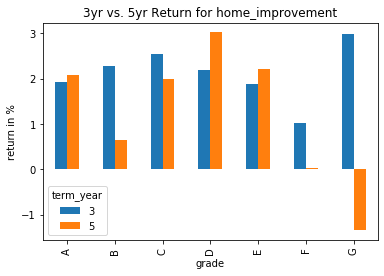

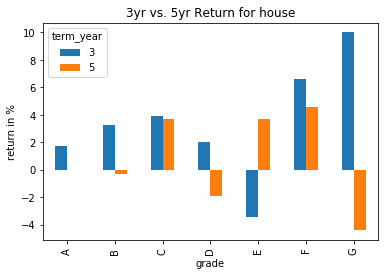

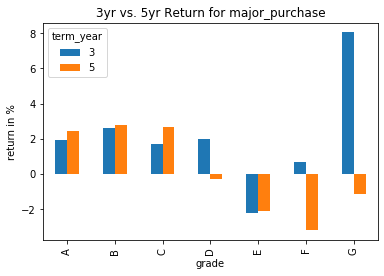

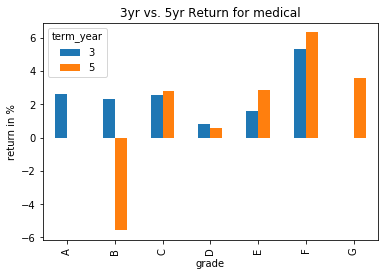

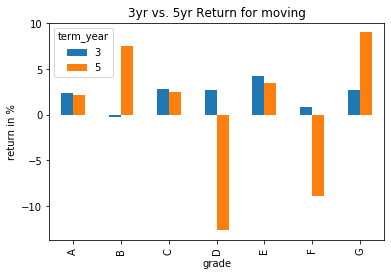

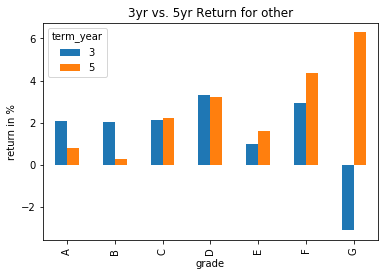

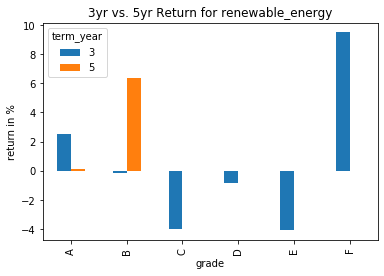

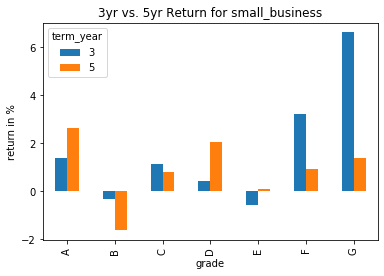

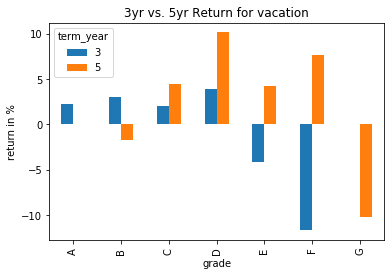

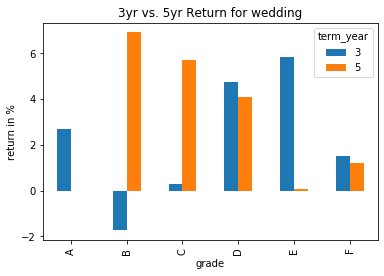

In [393]:
# Purpose by loan grade
purpose_grade_comp = df.loc[df.issue_year < 2016].groupby(['grade','purpose','term_year'])[['funded_amnt','total_pymnt']].sum().reset_index()
purpose_grade_comp['return'] = return_cal(purpose_grade_comp)

for purpose in purpose_grade_comp['purpose'].unique():
    df_purpose = purpose_grade_comp.loc[purpose_grade_comp.purpose == purpose][['grade','term_year','return']]
    df_purpose_pivot = pd.pivot_table(df_purpose, index='grade',values='return',columns='term_year')
    df_purpose_pivot.plot(kind='bar')
    plt.title('3yr vs. 5yr Return for ' + purpose)
    plt.ylabel('return in %')


### Question 33:

What happens if the issuance years are included in your analysis?

### Question 34:

Is there any pattern between loan duration vs return rate?

In [391]:
df.loc[df.issue_year < 2016].groupby(['grade'])[['funded_amnt','total_pymnt']].sum()

,funded_amnt,total_pymnt
grade,,
A,104852625.0,1.121958e+08
B,171747625.0,1.850104e+08
C,179451075.0,1.935457e+08
D,106969325.0,1.164344e+08
E,63559700.0,6.717591e+07
F,21952100.0,2.272954e+07
G,5995475.0,6.403511e+06


Text(0, 0.5, 'return in %')

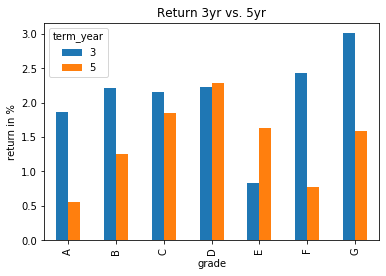

In [67]:
# This is simple weighted average return
term_comp = df.loc[df.issue_year < 2016].groupby(['grade','term_year'])[['funded_amnt','total_pymnt']].sum().reset_index()
term_comp['return_perc'] =  return_cal(term_comp)
term_comp_graph = pd.pivot_table(term_comp, index = 'grade',values = 'return_perc', columns = 'term_year')
term_comp_graph.plot(kind="bar")

plt.title('Return 3yr vs. 5yr')
plt.ylabel('return in %')



# Question Group: Survival Analysis on Survival Probabilities

- In the context of Lending Club Loans, a loan starts to default  121
121 days after it fails to make the payment on time.

### Question 35:

For loans which are eventually paid in full, analyze the probabilities of survival at different time durations (known as survival plot). How are these probabilities of 'survival' related to the loan grade/subgrade or the FICO scores of the borrowers? To visualize, you want to plot the so-called survival curve.

### Question 36:

For loans which are eventually defaulted, analyze the probabilities of survival at different time durations and find out its relationship with loan grade/subgrade, FICO scores or the other credit related attributes.

### Question 37:

Lumping defaulted loans and completed loans together, a loan either pre-pays early , defaults or completes at maturity. Perform survival analysis and study what features affect the patterns.

### Question 38:

You can either compute from the raw data from scratch, or use R-package like survminer to assist your analysis.

### Question 39:

In survival analysis jargon, the dual cause of the early termination of the loan (either early prepayment or default) is usually known as competing events/competing risks, or mixture cure model.

# Question Group: Data Analytics
- A good investor may want to avoid these types of loans
- The insights might be used in ML task to single out these bad loans

### Question 40: 

What types of loans tend to prepay and terminate within 3 months of the loan issuance?

### Question 41:

What types of loans tend to default (or go into charged off) within a short duration after issuance?

### Question 42:

Does default rate (including those get charged off or into settlement) holds constant across different time (year-months)?

### Question 43:

If not, what are the external driving forces which cause the default rate to rise or fall?

### Question 44:

Can you provide data and statistical evidence for your analysis?

# Question Group: Mini-Project

As a data scientist at **Lending Club**, provide strong evidence to educate the lenders why diversification is important.

- For simplicity, compare the investment returns of three types of loan portfolios
    - 20 equal-dollar investments in 20 grade A loans. 
    - 100 equal-dollar investments in 100 grade A loans.
    - 20 equal-dollar investments in $5+5+5+5$ loans in grade $A, B, C, D$, respectively, $5$
in each grade
    - 100 equal-dollar investments in $25+25+25+25$ loans in grade $A, B, C, D$, respectively,
 $25$ loans in each grade.
    - Or you can invest 1% (of the loan amount) and diversify into many loans

- Simulate uncertainty by randomly drawing from grade A, B, C, D loan buckets
    - Because loans often terminate prematurely, in order for the comparison to
be objective, you will need to annualize the returns by first computing the average
duration of your loan portfolios.
    - To be more accurate, you can take 'issuance date' into account and offer
simulation during different years (or year-months).
    - Due to the stochastic nature of the problem at hand, you should analyze
the mean annualized returns, risks of each type of portfolios, probability of loss, etc.

- Alternatively, as a data scientist at a start-up investing firm, provide a business report
whether loan-investing buying **Lending Club** loans is an attractive option, 
compared to short-term treasury/corporate funds?

